# Load the eval data

In [224]:
import os
import json
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import itertools
import os.path as osp
import matplotlib.pyplot as plt
from models.ep_nn import load_model

mat_name = 'isotropic-swift'
train_inp_name = 'pd_ms_42_200'

eval_inp_names = ['amplitude','cyclic','impulse','piecewise','resolution','bl_ms_42_200','gp_42_200','rw_42_200']
cols = ['name','network','output_type','k','p','q','seed','num_params']

model_folder = osp.join('metrics',mat_name,train_inp_name)
model_names = os.listdir(model_folder)


measure = 'RMSE'

In [225]:
results_glob, results_loc = [], []

for model_name in tqdm(model_names):
    model = load_model(osp.join(model_folder,model_name,'model.pth'))
    
    line_glob = [
        model.name,
        model.network_name, 
        model.output_type_name, 
        model.k,
        model.p,
        model.q,
        model.seed,
        model.num_params
    ]
    line_loc = line_glob.copy()
    
    eval_metrics_path = osp.join(model_folder,model_name,'eval_metrics.json',)
    test_eval_path = osp.join(model_folder,model_name,'test_eval.json',)
    
    with open(eval_metrics_path,'rb') as f:
        error_metrics = json.load(f)

    with open(test_eval_path,'rb') as f:
        test_eval = json.load(f)
    
    line_glob.append(test_eval['global'][measure]/1e6)
    line_loc.append(test_eval['local'][measure]/1e6)
    
    for eval_inp_name in eval_inp_names:

        line_glob.append(error_metrics[eval_inp_name]['global'][measure]/1e6)
        line_loc.append(error_metrics[eval_inp_name]['local'][measure]/1e6)

    results_glob.append(line_glob)
    results_loc.append(line_loc)


df_glob = pd.DataFrame(results_glob, columns=cols+['test']+eval_inp_names)
df_loc = pd.DataFrame(results_loc, columns=cols+['test']+eval_inp_names)

100%|██████████| 184/184 [00:04<00:00, 39.64it/s]


# Eval the modelling approach

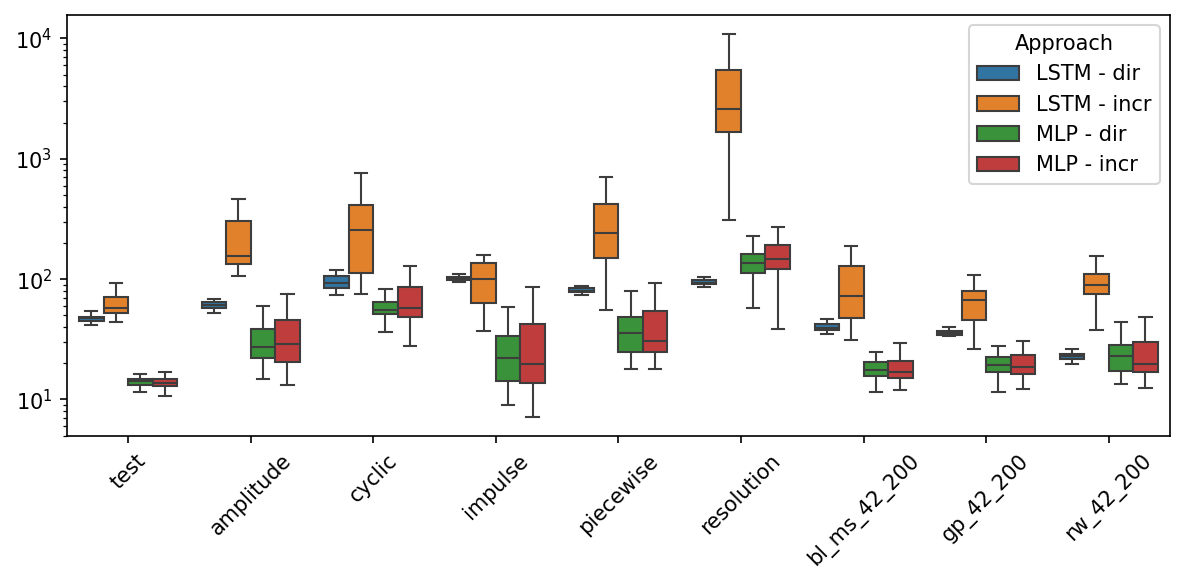

In [232]:
df_tmp = df_glob[['network','output_type'] + ['test'] + eval_inp_names]
df_tmp = df_tmp.melt(id_vars=['network','output_type'], var_name='dataset', value_name='score')
df_tmp['approach'] = df_tmp['network'] + ' - ' + df_tmp['output_type']

plt.figure(figsize=(8,4),dpi=150)
sns.boxplot(x='dataset', y='score', hue='approach', data=df_tmp, showfliers=False)
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Approach')
plt.tight_layout()
plt.show()

Plot the top 3 surrogate models on piecewise set (based on global and local error)

In [233]:
df_glob.sort_values('test')[:3][['name','num_params','test'] + eval_inp_names]

,name,num_params,test,amplitude,cyclic,impulse,piecewise,resolution,bl_ms_42_200,gp_42_200,rw_42_200
118,MLP-dir-8-8-5-90,369,9.799041,60.371852,69.851846,45.234978,57.071735,113.162854,15.320519,19.814875,25.635671
102,MLP-dir-5-8-5-90,321,9.890175,26.809655,54.233889,34.703128,49.410189,67.803509,12.343352,12.669523,14.361599
135,MLP-incr-2-8-8-75,489,10.772793,57.111994,68.105003,38.234182,89.043101,114.984990,30.922366,16.152404,19.853634


/tmp/ipykernel_31482/3658959116.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_MLP_dir = df_glob[df_glob['network'] == network_name][df_glob['output_type'] == output_type]


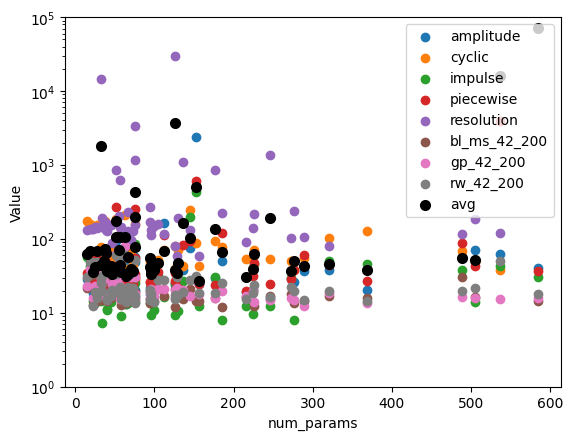

In [234]:
network_name = 'MLP'
output_type = 'incr'
param = 'num_params'


df_MLP_dir = df_glob[df_glob['network'] == network_name][df_glob['output_type'] == output_type]
df_MLP_dir = df_MLP_dir[['name',param]+eval_inp_names]
df_MLP_dir = df_MLP_dir.sort_values(param)
df_MLP_dir['avg_error'] = df_MLP_dir[eval_inp_names].mean(axis=1)


for eval_inp_name in eval_inp_names:
    plt.scatter(
        df_MLP_dir[param],
        df_MLP_dir[eval_inp_name],
        label=eval_inp_name,
        lw=1
    )

plt.scatter(
    df_MLP_dir[param],
    df_MLP_dir['avg_error'],
    label='avg',
    color='black',
    lw=2
)


plt.xlabel(param)
plt.yscale('log')
plt.ylim(10e-1,10e4)
plt.ylabel("Value")
plt.legend()
plt.show()

In [235]:
df = df_glob[['name'] + ['test'] + eval_inp_names]

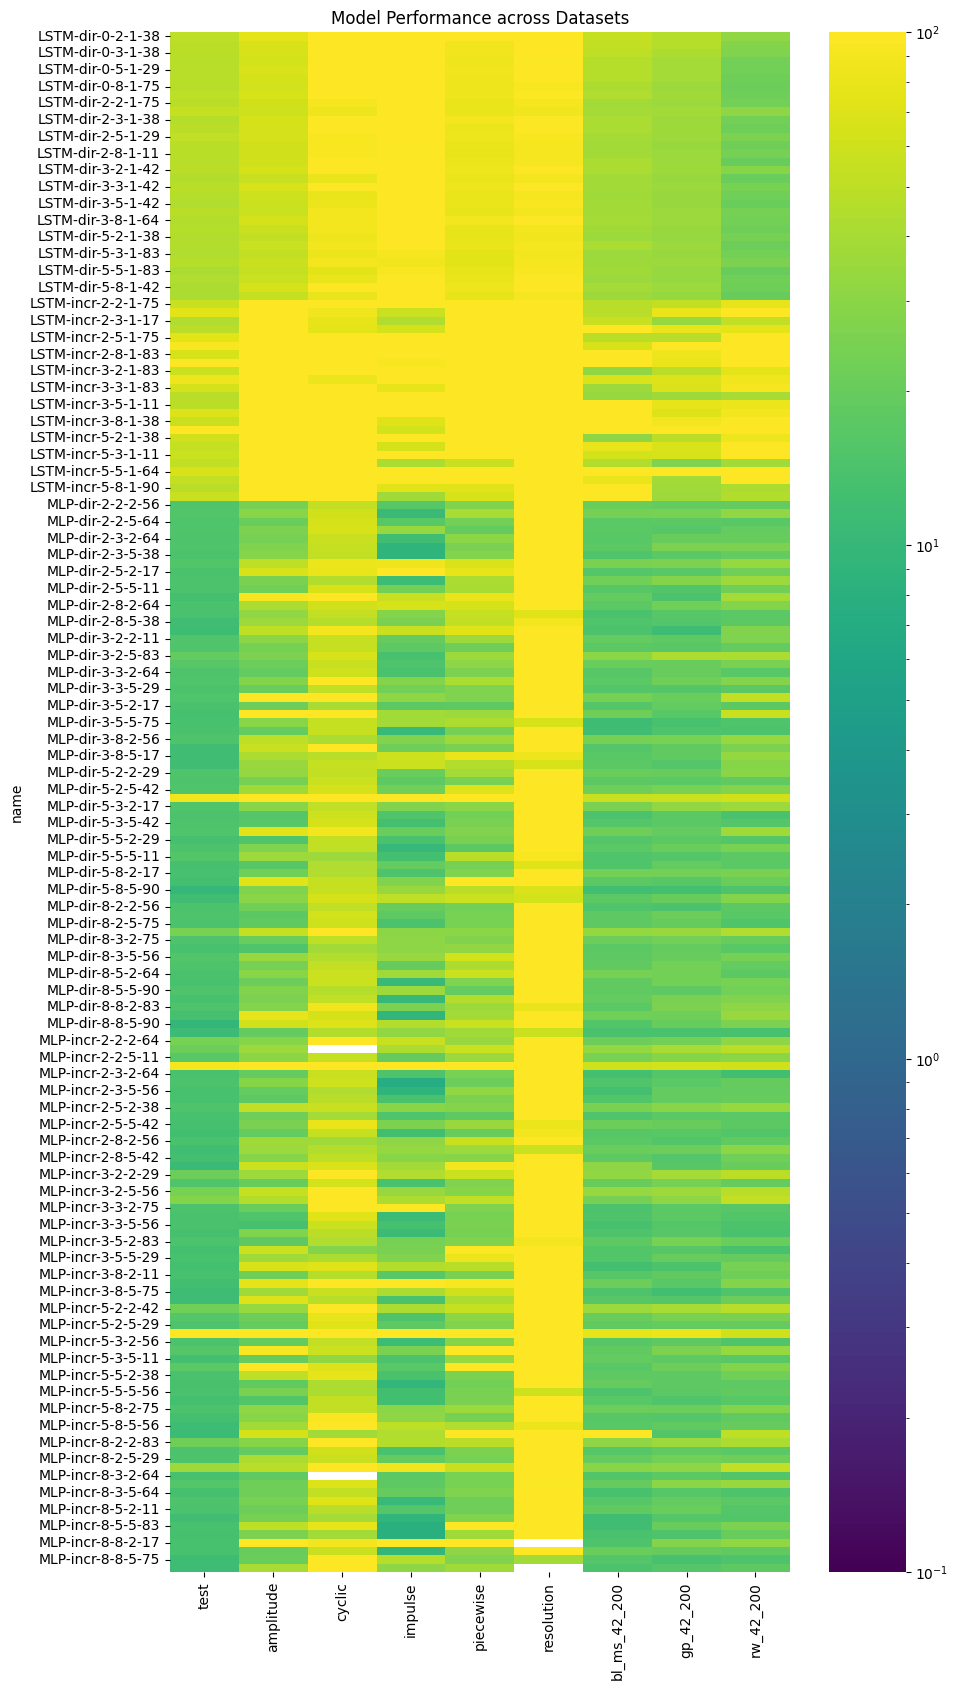

In [236]:
import seaborn as sns
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 20))
sns.heatmap(
    df.set_index('name'), 
    cmap='viridis', 
    cbar=True,
    norm=LogNorm(vmin=1e-1, vmax=1e2)
)
plt.title("Model Performance across Datasets")
plt.show()

In [237]:
df = df.drop('resolution', axis=1)

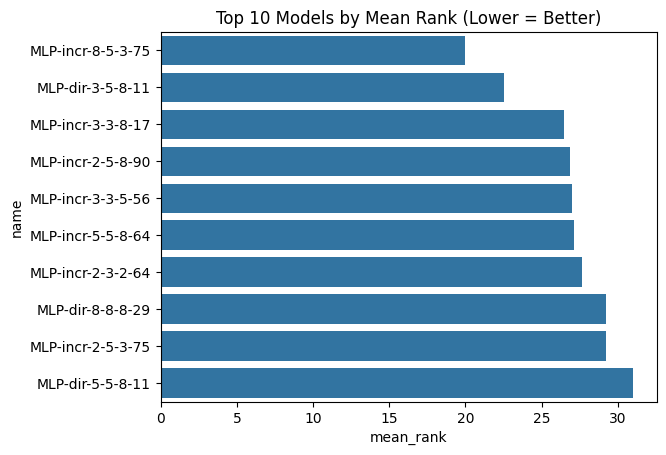

,name,test,amplitude,cyclic,impulse,piecewise,bl_ms_42_200,gp_42_200,rw_42_200
83,MLP-dir-3-5-8-11,13.831609,19.062924,54.030264,10.540634,23.633131,12.048257,14.396673,14.310530
99,MLP-dir-5-5-8-11,13.174245,16.210302,44.326654,19.095188,23.542741,14.781105,18.863670,16.866428
119,MLP-dir-8-8-8-29,10.990698,19.371029,44.862364,31.854786,37.089897,13.633364,13.778240,13.353818
124,MLP-incr-2-3-2-64,13.750434,18.820586,56.696647,14.521752,24.008558,12.701390,15.661192,12.436611
129,MLP-incr-2-5-3-75,13.308254,22.029534,39.424596,14.760566,18.045071,15.097444,17.069853,17.296721
131,MLP-incr-2-5-8-90,12.485945,18.937103,53.985869,12.363399,19.990506,16.139590,16.653720,15.494463
142,MLP-incr-3-3-5-56,13.851421,13.212519,56.940067,13.195790,24.596125,13.567244,15.704617,14.035656
143,MLP-incr-3-3-8-17,13.171471,26.428045,49.159902,11.067247,23.536737,14.527016,16.224657,13.940646
163,MLP-incr-5-5-8-64,12.817309,15.218165,52.750084,12.369635,24.715602,16.733200,14.984681,16.590463
177,MLP-incr-8-5-3-75,12.018798,23.600359,39.294479,9.214984,26.920686,11.975162,15.707691,15.145502


In [238]:

df_rank = df[df.columns[1:]].rank(axis=0, ascending=True)
df_rank['mean_rank'] = df_rank.mean(axis=1)
df_rank['name'] = df['name']

top = df_rank.sort_values('mean_rank').head(10)
sns.barplot(y='name', x='mean_rank', data=top)
plt.title("Top 10 Models by Mean Rank (Lower = Better)")
plt.show()

df[df['name'].isin(top['name'])]

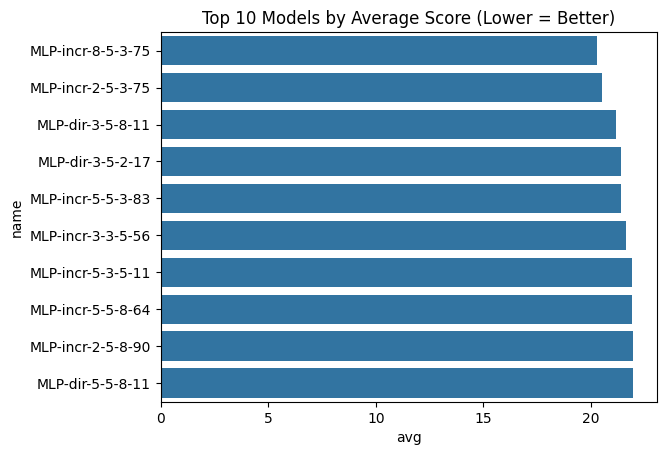

,name,test,amplitude,cyclic,impulse,piecewise,bl_ms_42_200,gp_42_200,rw_42_200,avg
177,MLP-incr-8-5-3-75,12.018798,23.600359,39.294479,9.214984,26.920686,11.975162,15.707691,15.145502,20.265552
129,MLP-incr-2-5-3-75,13.308254,22.029534,39.424596,14.760566,18.045071,15.097444,17.069853,17.296721,20.531969
83,MLP-dir-3-5-8-11,13.831609,19.062924,54.030264,10.540634,23.633131,12.048257,14.396673,14.310530,21.146059
80,MLP-dir-3-5-2-17,13.804944,21.436019,40.770635,17.704750,17.805709,15.554065,18.880857,17.506594,21.379804
161,MLP-incr-5-5-3-83,13.410497,18.431785,43.290236,9.468811,23.274347,19.451435,18.205435,17.790865,21.416131
142,MLP-incr-3-3-5-56,13.851421,13.212519,56.940067,13.195790,24.596125,13.567244,15.704617,14.035656,21.607431
158,MLP-incr-5-3-5-11,12.854032,20.313526,31.472579,14.045802,33.790940,18.867272,17.966613,16.769408,21.889449
163,MLP-incr-5-5-8-64,12.817309,15.218165,52.750084,12.369635,24.715602,16.733200,14.984681,16.590463,21.908833
131,MLP-incr-2-5-8-90,12.485945,18.937103,53.985869,12.363399,19.990506,16.139590,16.653720,15.494463,21.937807
99,MLP-dir-5-5-8-11,13.174245,16.210302,44.326654,19.095188,23.542741,14.781105,18.863670,16.866428,21.955155


In [239]:
# Compute the average score across columns (excluding 'name')
tmp = eval_inp_names.copy()
tmp.remove('resolution')
df.loc[:, 'avg'] = df[tmp].mean(axis=1)

# Select the top 10 models with highest average score
top = df.sort_values('avg', ascending=True).head(10)

# Plot
sns.barplot(y='name', x='avg', data=top)
plt.title("Top 10 Models by Average Score (Lower = Better)")
plt.show()
top